In [1]:
import numpy as np
import tensorflow as tf
from util import ImShow as I
import matplotlib.pyplot as plt

(5182, 784)


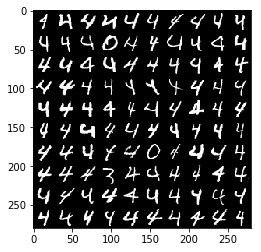

In [2]:
data = np.load(r"data/4_other_x.npk")
print data.shape
pic_X = I.tile_raster_images(X=data, img_shape=(28,28), tile_shape=(10,10))
plt.imshow(pic_X,cmap='gray')
plt.show()

In [3]:
input_dim = 784
h_dim = 500
latent_dim = 20
num = 500
learning_rate = 0.001
lam = 0.5

In [4]:
def init(shape,rtype='uniform'):
    if rtype == 'normal':
        return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))
    if rtype == 'uniform':
        if len(shape) == 2:
            init_max_value = np.sqrt(6. / (shape[0] + shape[1]))
            return tf.random_uniform(shape,np.negative(init_max_value),init_max_value)
        else:
            init_max_value = np.sqrt(6. / (shape[0]))
            return tf.random_uniform(shape,np.negative(init_max_value),init_max_value)

In [6]:
with tf.Graph().as_default():
    with tf.Session() as sess:
        init_max_value = np.sqrt(6. / (latent_dim + input_dim))
        input_x = tf.placeholder(dtype= tf.float32, shape=[num, input_dim])
        hidden_h = tf.Variable(init(shape=(num, latent_dim)))
        
        W1 = tf.Variable(init(shape=(latent_dim, h_dim)))
        b1 = tf.Variable(init(shape=[h_dim]))
        W2 = tf.Variable(init(shape=(h_dim, input_dim)))
        b2 = tf.Variable(init(shape=[input_dim]))
        
        hidden_mean_weight = tf.Variable(init([latent_dim,latent_dim]))
        hidden_mean_bias = tf.Variable(init([latent_dim]))
        hidden_variance_weight = tf.Variable(init([latent_dim,latent_dim]))
        hidden_variance_bias = tf.Variable(init([latent_dim]))
        
        
        recon = tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(hidden_h,W1) + b1), W2) + b2) 
        
        mean = tf.matmul(hidden_h, hidden_mean_weight) + hidden_mean_bias
        variance = tf.matmul(hidden_h, hidden_variance_weight) + hidden_variance_bias
        
        recon_loss = tf.norm(input_x-recon,ord=2)
        ## close to gaussian loss
        gaussian_loss = lam * tf.reduce_sum(-0.5 * tf.reduce_sum((1 + variance - tf.square(mean) - tf.exp(variance)),1))
        loss = tf.reduce_mean(recon_loss +  gaussian_loss)
        
        optimizer = tf.train.RMSPropOptimizer(learning_rate = learning_rate)
        train_op = optimizer.minimize(loss)
        
        global_init = tf.global_variables_initializer()
        
        sess.run(global_init)
        
        for i in range(1, 5000+1):
            # Prepare Data
            # Get the next batch of MNIST data (only images are needed, not labels)
#             batch_x, _ = mnist.train.next_batch(num)

            # Train
            feed_dict = {input_x: data[0:500]}
            _, l,rl,gl = sess.run([train_op, loss,recon_loss,gaussian_loss], feed_dict=feed_dict)
            if i % 1000 == 0 or i == 1:
                print('Step %i, Loss: %f' % (i, l))
                print "recon", rl
                print "gaussian", gl

Step 1, Loss: 734.394409
recon 196.91684
gaussian 537.4776
Step 1000, Loss: 75.421967
recon 75.34408
gaussian 0.07788563
Step 2000, Loss: 56.270073
recon 56.249653
gaussian 0.020419702
Step 3000, Loss: 51.723347
recon 51.70205
gaussian 0.021297172
Step 4000, Loss: 47.710304
recon 47.70333
gaussian 0.0069749057
Step 5000, Loss: 46.864498
recon 46.849693
gaussian 0.014804035


## Sparse version: True auto-completion

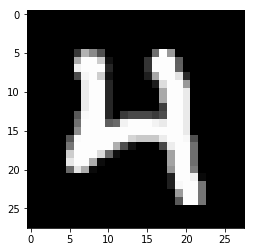

set([(25, 10), (2, 16), (14, 5), (8, 11), (16, 8), (3, 11), (10, 24), (0, 3), (20, 4), (6, 17)])


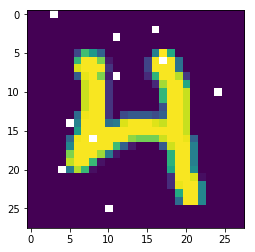

In [23]:
input_dim = 28
h_dim = 20
latent_dim = 5
num = 28
learning_rate = 0.001
lam = 0.2

shape = (28,28)
x = data[1].reshape(shape)
plt.imshow(x,cmap='gray')
plt.show()

missing_indice = set([(i,j) for i,j in zip(np.random.choice(range(28),10), np.random.choice(range(28),10))])
print missing_indice
missing_x = x.copy()
for i,j in missing_indice:
    missing_x[i,j] = np.nan

plt.imshow(missing_x)
plt.show()

indices = []
values = []

for i in range(shape[0]):
    for j in range(shape[1]):
        if not np.isnan(missing_x[i,j]):
            indices.append((i,j))
            values.append(missing_x[i,j])
indices = np.array(indices,dtype=np.int32)

In [30]:
with tf.Graph().as_default():
    with tf.Session() as sess:
        init_max_value = np.sqrt(6. / (latent_dim + input_dim))
        input_x = tf.sparse_placeholder(dtype = tf.float32, shape=(20,20),name="input_x")
        hidden_h = tf.Variable(init(shape=(num, latent_dim)))
        
        W1 = tf.Variable(init(shape=(latent_dim, h_dim)))
        b1 = tf.Variable(init(shape=[h_dim]))
        W2 = tf.Variable(init(shape=(h_dim, input_dim)))
        b2 = tf.Variable(init(shape=[input_dim]))
        
        hidden_mean_weight = tf.Variable(init([latent_dim,latent_dim]))
        hidden_mean_bias = tf.Variable(init([latent_dim]))
        hidden_variance_weight = tf.Variable(init([latent_dim,latent_dim]))
        hidden_variance_bias = tf.Variable(init([latent_dim]))
        
        
        recon = tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(hidden_h,W1) + b1), W2) + b2) 
        
        mean = tf.matmul(hidden_h, hidden_mean_weight) + hidden_mean_bias
        variance = tf.matmul(hidden_h, hidden_variance_weight) + hidden_variance_bias
        
        
        x = tf.sparse_tensor_to_dense(input_x)

        proj_x = tf.manip.gather_nd(params=x, indices= indices, name='proj_x')
        proj_recon = tf.manip.gather_nd(params=recon, indices= indices, name='proj_simu')
        recon_loss = tf.norm(proj_x-proj_recon, ord=2)
        
        ## close to gaussian loss
        gaussian_loss = lam * tf.reduce_sum(-0.5 * tf.reduce_sum((1 + variance - tf.square(mean) - tf.exp(variance)),1))
        loss = tf.reduce_mean(recon_loss +  gaussian_loss)
        
        optimizer = tf.train.RMSPropOptimizer(learning_rate = learning_rate)
        train_op = optimizer.minimize(loss)
        
        global_init = tf.global_variables_initializer()
        
        sess.run(global_init)
        
        for i in range(1, 50000+1):
            # Prepare Data
            # Get the next batch of MNIST data (only images are needed, not labels)
#             batch_x, _ = mnist.train.next_batch(num)

            # Train
            feed_dict = {input_x: tf.SparseTensorValue(indices,values,shape)}
            _, l,rl,gl,filled = sess.run([train_op, loss,recon_loss,gaussian_loss,recon], feed_dict=feed_dict)
            if i % 3000 == 0 or i == 1:
                print('Step %i, Loss: %f' % (i, l))
                print "recon", rl
                print "gaussian", gl

Step 1, Loss: 29.141045
recon 12.664962
gaussian 16.476082
Step 3000, Loss: 3.352161
recon 3.3520007
gaussian 0.00016081333
Step 6000, Loss: 3.337691
recon 3.3376608
gaussian 2.991557e-05
Step 9000, Loss: 3.335549
recon 3.3355184
gaussian 3.103614e-05
Step 12000, Loss: 3.335716
recon 3.3356843
gaussian 3.15547e-05
Step 15000, Loss: 3.335154
recon 3.3351219
gaussian 3.1608342e-05
Step 18000, Loss: 3.332760
recon 3.3327258
gaussian 3.4332275e-05
Step 21000, Loss: 3.332927
recon 3.332891
gaussian 3.554225e-05
Step 24000, Loss: 3.332430
recon 3.332395
gaussian 3.4707784e-05
Step 27000, Loss: 3.332150
recon 3.3321183
gaussian 3.2031538e-05
Step 30000, Loss: 3.332548
recon 3.3325176
gaussian 3.0452013e-05
Step 33000, Loss: 3.331517
recon 3.3314884
gaussian 2.8681756e-05
Step 36000, Loss: 3.331464
recon 3.331437
gaussian 2.6607513e-05
Step 39000, Loss: 3.331830
recon 3.3318052
gaussian 2.4431944e-05
Step 42000, Loss: 3.330891
recon 3.3308685
gaussian 2.2113323e-05
Step 45000, Loss: 3.331216
r

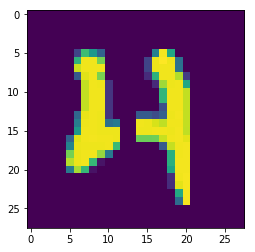

In [31]:
plt.imshow(filled)
plt.show()